In [1]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random

In [2]:
df = pd.read_csv("dataframe_12g_5m.csv")
n_days = 11
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
df.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-19 15:20:00+00:00,29.55,41.00,1017.5,0.0
2020-07-19 15:25:00+00:00,29.55,41.10,1017.5,0.0
2020-07-19 15:30:00+00:00,29.55,41.05,1017.5,0.0
2020-07-19 15:35:00+00:00,29.55,41.00,1017.5,0.0
2020-07-19 15:40:00+00:00,29.55,41.05,1017.5,0.0


In [3]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


In [4]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [9]:
# divide in train e test
size = points_per_day#len(df)- (points_per_day*1)
# size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [10]:
points_per_day = int(len(df)/n_days) 
start_date = df_test.index[0]
end_date = df_test.index[24]#df_test.index[points_per_day-1]
end_pred = 24 #points_per_day-1

# Temperature

In [33]:
# fit model
model = ExponentialSmoothing(df_train.temperature, seasonal="add",seasonal_periods = 288)#trend = "add")#, seasonal = "mul", seasonal_periods=500)
model_fit = model.fit()#optimized=True)#, use_boxcox=True, remove_bias=True)

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

model_fit.save('./hwes_temp_model.pkl')

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  314
Model:             ExponentialSmoothing   SSE                              0.039
Optimized:                         True   AIC                          -2246.289
Trend:                             None   BIC                          -1158.965
Seasonal:                      Additive   AICC                          5901.901
Seasonal Periods:                   288   Date:                 Mon, 20 Jul 2020
Box-Cox:                          False   Time:                         18:12:53
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9999997                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


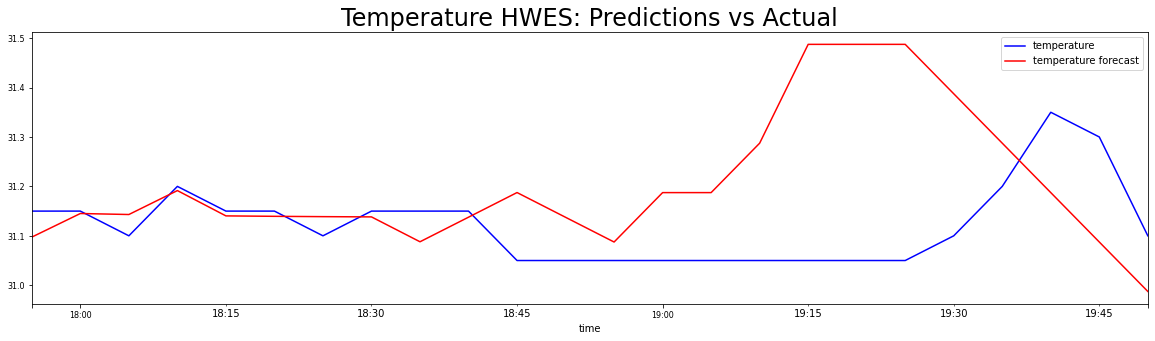

MAE 0.13348661178976626
MSE 0.03671836477783916


In [34]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "temperature forecast")
plt.title("Temperature HWES: Predictions vs Actual", size = 24)
plt.tick_params(labelsize=8)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.temperature[:end_pred], df_forecast)))

# Humidity

In [35]:
# fit model
model = ExponentialSmoothing(df_train.humidity, trend="add",seasonal_periods = 288)#trend="add")# seasonal="mul",seasonal_periods = 288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

model_fit.save('./hwes_hum_model.pkl')

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  314
Model:             ExponentialSmoothing   SSE                              6.107
Optimized:                         True   AIC                          -1229.168
Trend:                         Additive   BIC                          -1214.170
Seasonal:                          None   AICC                         -1228.894
Seasonal Periods:                  None   Date:                 Mon, 20 Jul 2020
Box-Cox:                          False   Time:                         18:12:54
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope            0.30428

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


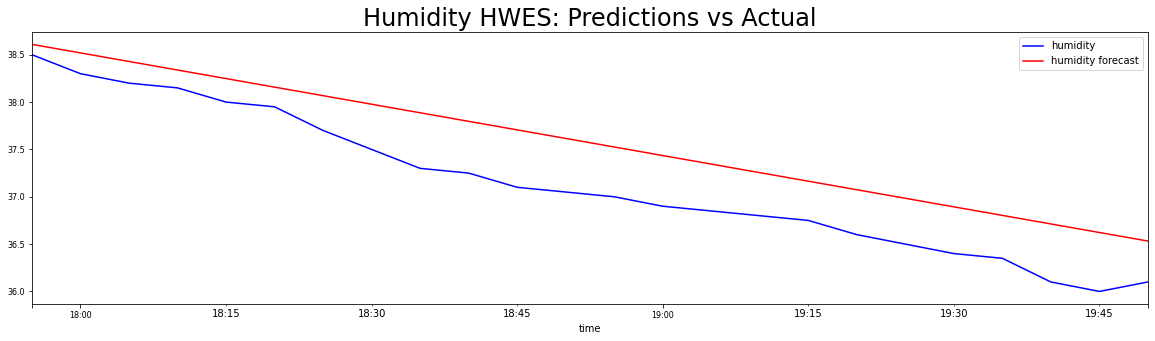

MAE 0.4313543683348294
MSE 0.20803290784298603


In [36]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "humidity forecast")
plt.title("Humidity HWES: Predictions vs Actual", size = 24)
plt.tick_params(labelsize=8)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.humidity[:end_pred], df_forecast)))

# Pressure

In [37]:
# fit model
model = ExponentialSmoothing(df_train.pressure, seasonal="add",seasonal_periods = 288) #seasonal = "mul", seasonal_periods=288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

model_fit.save('./hwes_press_model.pkl')

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  314
Model:             ExponentialSmoothing   SSE                              0.500
Optimized:                         True   AIC                          -1442.958
Trend:                             None   BIC                           -355.634
Seasonal:                      Additive   AICC                          6705.233
Seasonal Periods:                   288   Date:                 Mon, 20 Jul 2020
Box-Cox:                          False   Time:                         18:12:56
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9999000                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


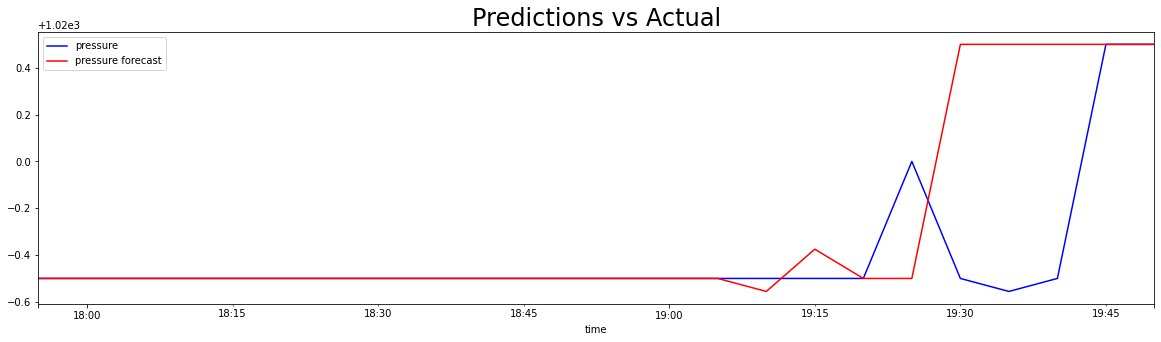

MAE 0.15567129629629525
MSE 0.14095453960905233


In [38]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "pressure forecast")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.pressure[:end_pred], df_forecast)))